In [1]:
# Check GPU enable on Colab
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   1158      0 --:--:-- --:--:-- --:--:--  1154
Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
# Import
from fastai.basics import *

# Setup 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# MNIST SGD

## Dataset

Get the `pickled` MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz.

In [0]:
path = Config().data_path()

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/mnist.pkl.gz')]

In [0]:
with gzip.open(path/"mnist.pkl.gz", "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

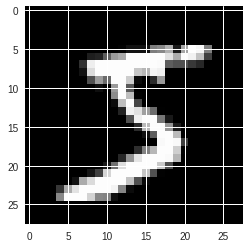

In [7]:
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")

In [9]:
x_train.shape

(50000, 784)

In [0]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

In [12]:
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [0]:
bs = 64

In [0]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [18]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
        
    
    def forward(self, xb):
        return self.lin(xb)

In [0]:
model = Mnist_Logistic().cuda()

In [31]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [32]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [33]:
model(x).shape

torch.Size([64, 10])

In [34]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr = 2e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x, y ,lr):
    wd = 1e-5
    y_hat = model(x)
    w2 = 0
    for p in model.parameters():
        w2 += (p**2).sum()
        
    loss = loss_func(y_hat, y) + w2 * wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x, y, lr) for x, y in data.train_dl]

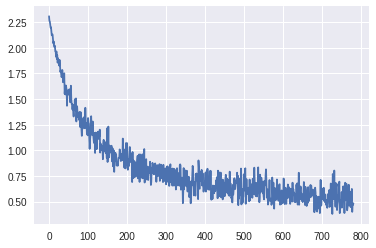

In [41]:
plt.plot(losses)

In [0]:
class Mnist_NN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x, y, lr) for x, y in data.train_dl]

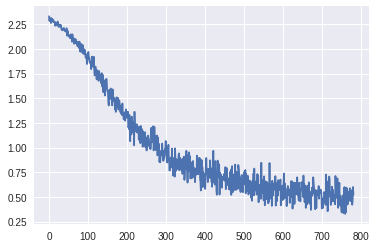

In [46]:
plt.plot(losses)

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x, y, lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x, y, 1e-3) for x, y in data.train_dl]

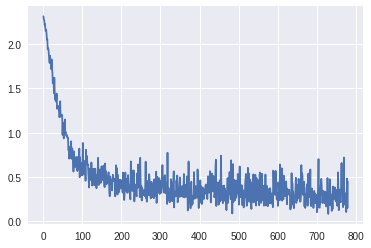

In [52]:
plt.plot(losses)

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


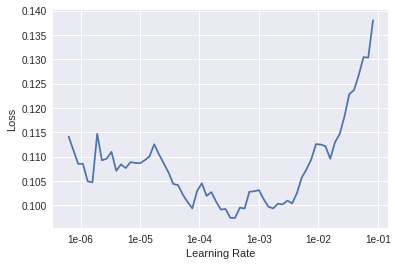

In [60]:
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.151716,0.134720,0.961200,00:04


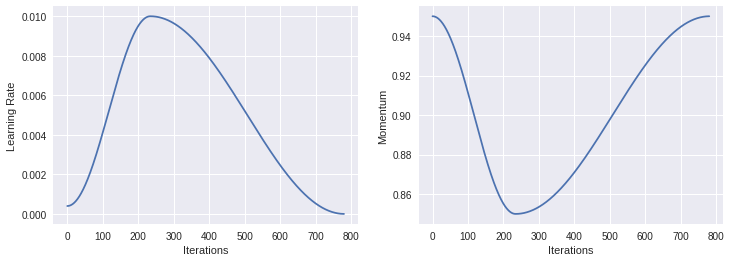

In [57]:
learn.recorder.plot_lr(show_moms=True)

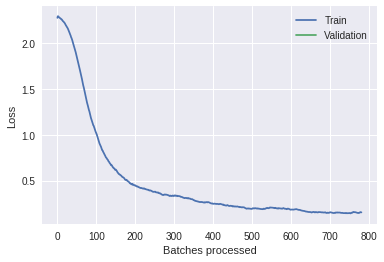

In [58]:
learn.recorder.plot_losses()